In [16]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch import nn, optim
from time import time
#Allows showing plots in notebook:
%matplotlib inline
from torchvision import datasets, transforms
#import imageio

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


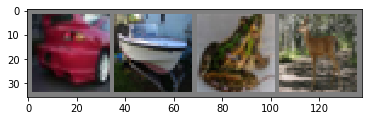

  car  ship  frog  deer


In [51]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
print('the number of images in the train set:', len(trainset))
print('the number of images in the validation/test set:', len(testset))

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

the number of images in the train set: 50000
the number of images in the validation/test set: 10000
torch.Size([4, 3, 32, 32])
torch.Size([4])


# Your code should go below: